In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
df=pd.read_excel(r'C:\Users\DELL\Downloads\1730285881-Airbnb_Open_Data.xlsx')
df

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102594,6092437,Spare room in Williamsburg,12312296767,verified,Krik,Brooklyn,Williamsburg,40.70862,-73.94651,United States,...,169.0,1.0,0.0,NaT,NaN,3.0,1.0,227.0,No Smoking No Parties or Events of any kind Pl...,NaN
102595,6092990,Best Location near Columbia U,77864383453,unconfirmed,Mifan,Manhattan,Morningside Heights,40.80460,-73.96545,United States,...,167.0,1.0,1.0,2015-07-06,0.02,2.0,2.0,395.0,House rules: Guests agree to the following ter...,NaN
102596,6093542,"Comfy, bright room in Brooklyn",69050334417,unconfirmed,Megan,Brooklyn,Park Slope,40.67505,-73.98045,United States,...,198.0,3.0,0.0,NaT,NaN,5.0,1.0,342.0,NaN,NaN
102597,6094094,Big Studio-One Stop from Midtown,11160591270,unconfirmed,Christopher,Queens,Long Island City,40.74989,-73.93777,United States,...,109.0,2.0,5.0,2015-10-11,0.10,3.0,1.0,386.0,NaN,NaN


In [58]:
#Standardize the columns names
df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]

print(df.head())
print('Loaded data and standardized column names')

        id                                              name      host_id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                               Home away from home  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host_name neighbourhood_group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2            unconfirmed     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service_fee  minimum_nights  \
0  40.64749 -73.97237  United S

In [57]:
# Convert common numeric/date columns if present, impute simple nulls, remove duplicates
num_cols = [
    'price','service_fee','minimum_nights','number_of_reviews',
    'reviews_per_month','review_rate_number','calculated_host_listings_count',
    'availability_365','lat','long','construction_year'
]
date_cols = ['last_review']

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Simple imputations
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode().iloc[0]) if df[col].notna().any() else df[col]

# Drop perfect duplicates
df = df.drop_duplicates()

print(df.head())
print('Converted types, imputed basic nulls, and dropped duplicates')

        id                                              name      host_id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                               Home away from home  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host_name neighbourhood_group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2            unconfirmed     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service_fee  minimum_nights  \
0  40.64749 -73.97237  United S

In [65]:
# Cap extreme values at 1st/99th percentiles for numeric metrics (not IDs)
id_like = {'id','host_id'}
cap_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in id_like]

for c in cap_cols:
    q1 = df[c].quantile(0.01)
    q99 = df[c].quantile(0.99)
    df[c] = df[c].clip(lower=q1, upper=q99)

print(df[cap_cols].describe().T)
print('Winsorized numeric metrics at 1st/99th percentiles')

                                   count         mean         std  \
lat                             102058.0    40.728091    0.055156   
long                            102058.0   -73.949161    0.046941   
instant_bookable                101953.0     0.497945    0.499998   
construction_year               102058.0  2012.487066    5.759833   
price                           102058.0   625.345568  331.069367   
service_fee                     102058.0   125.039752   66.206058   
minimum_nights                  102058.0     7.132621   10.459577   
number_of_reviews               102058.0    26.664122   44.330723   
reviews_per_month               102058.0     1.251834    1.402335   
review_rate_number              102058.0     3.277862    1.283174   
calculated_host_listings_count  102058.0     7.033432   24.826425   
availability_365                102058.0   140.716299  134.445683   

                                        min         25%         50%  \
lat                            

C:\Users\DELL\AppData\Local\Temp\ipykernel_8624\1694282602.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].clip(lower=q1, upper=q99)
C:\Users\DELL\AppData\Local\Temp\ipykernel_8624\1694282602.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].clip(lower=q1, upper=q99)
C:\Users\DELL\AppData\Local\Temp\ipykernel_8624\1694282602.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

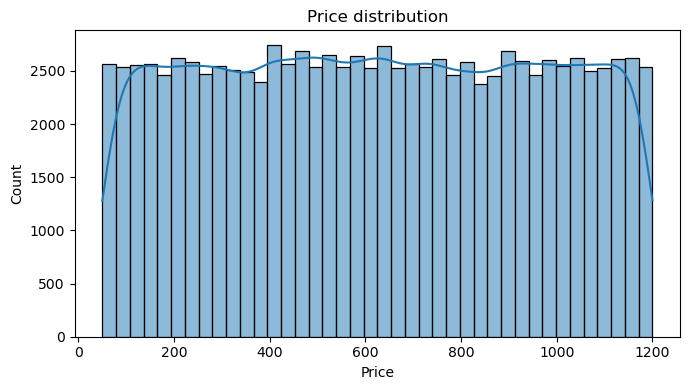

In [53]:
# Price distribution
plt.figure(figsize=(7,4))
sns.histplot(df['price'], bins=40, kde=True)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

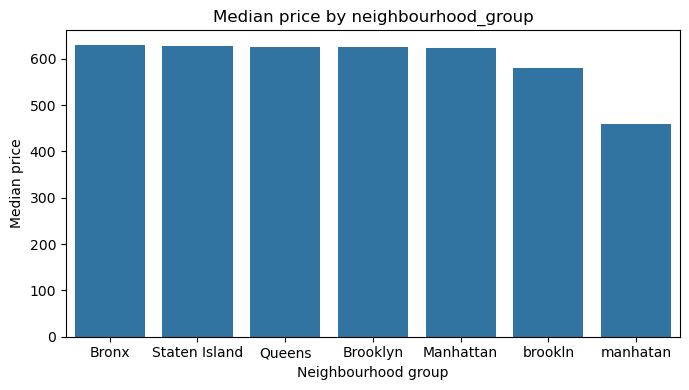

Displayed head and quick visuals


In [60]:
# Average price by neighbourhood_group (if available)
if 'neighbourhood_group' in df.columns:
    plt.figure(figsize=(7,4))
    order = df.groupby('neighbourhood_group')['price'].median().sort_values(ascending=False).index
    sns.barplot(data=df, x='neighbourhood_group', y='price', order=order, estimator=np.median, errorbar=None)
    plt.title('Median price by neighbourhood_group')
    plt.xlabel('Neighbourhood group')
    plt.ylabel('Median price')
    plt.tight_layout()
    plt.show()

print('Displayed head and quick visuals')

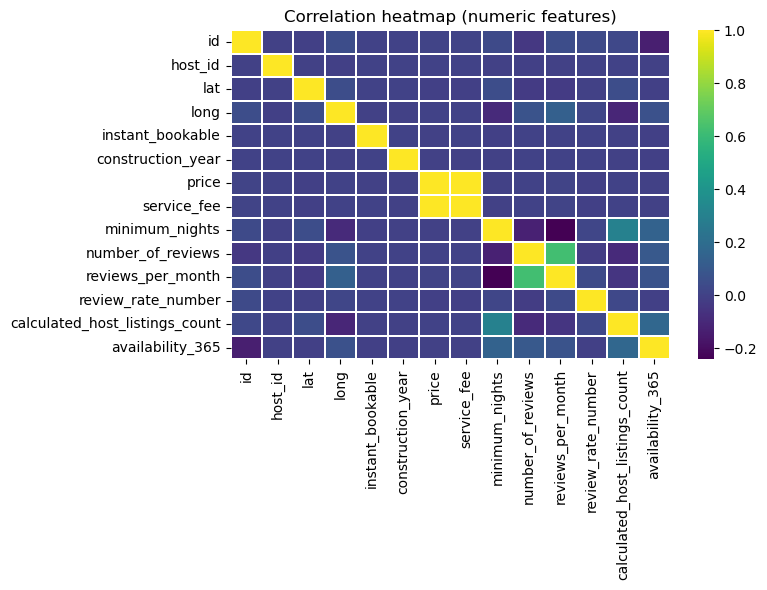

In [64]:

# - Shows a correlation heatmap for numeric columns
try:
    df
except NameError:
    df = pd.read_excel('1730285881-Airbnb_Open_Data.xlsx')
    df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]

# Ensure numeric for correlations
num_df = df.select_dtypes(include=[np.number]).copy()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(num_df.corr(numeric_only=True), cmap='viridis', annot=False, linewidths=0.2)
plt.title('Correlation heatmap (numeric features)')
plt.tight_layout()
plt.show()


  


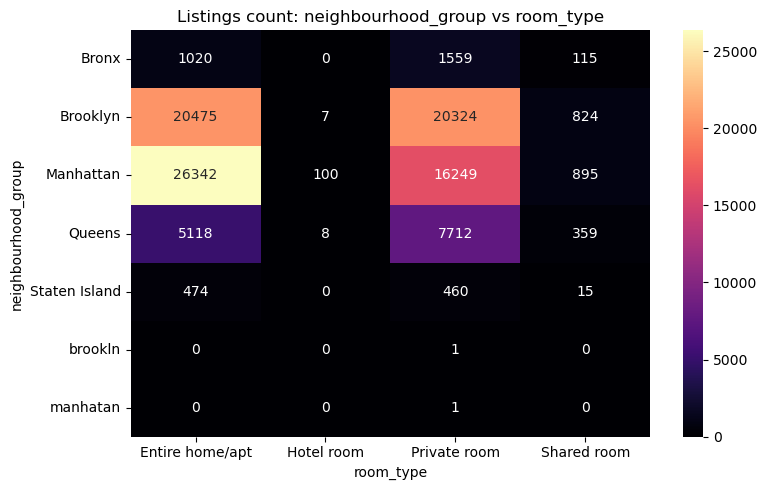

In [63]:
# Neighborhood vs Room Type heatmap
if 'neighbourhood_group' in df.columns and 'room_type' in df.columns:
    piv = pd.pivot_table(df, index='neighbourhood_group', columns='room_type', values=df.columns[0], aggfunc='count', fill_value=0)
    plt.figure(figsize=(8,5))
    sns.heatmap(piv, cmap='magma', annot=True, fmt='d')
    plt.title('Listings count: neighbourhood_group vs room_type')
    plt.xlabel('room_type')
    plt.ylabel('neighbourhood_group')
    plt.tight_layout()
    plt.show()